# PreProcessing, EDA and Feature extraction notebook

## Importing libraries and packages installation

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import json
import re
import string
from tqdm import tqdm
import sys
import subprocess
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp
from datasets import load_dataset
import unicodedata
import contractions
from scipy.stats import pearsonr

In [38]:
# Check and install required packages
def install_package(package):
    print(f"Installing {package}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [39]:
# Install transformers for BERT if necessary
try:
    import torch
    from transformers import AutoTokenizer, AutoModel, pipeline
except ImportError:
    print("Installing required packages for BERT...")
    install_package("torch")
    install_package("transformers")
    import torch
    from transformers import AutoTokenizer, AutoModel, pipeline

In [40]:
# Install sentence-transformers for sentence embeddings
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    install_package("sentence-transformers")
    from sentence_transformers import SentenceTransformer

In [41]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [42]:
# Load dataset and apply preprocessing
print("Loading dataset...")
df = load_dataset("ayjays132/Emotionverse")
df = pd.DataFrame(df['train'])

Loading dataset...


In [43]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /Users/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lucas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lucas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [44]:
# Initialize NLTK resources
#stop_words = set(stopwords.words('english')) - {"no", "not", "nor"}
lemmatizer = WordNetLemmatizer()

## PreProcessing

In [45]:
# Preprocessing functions
def normalize_unicode(text):
    return unicodedata.normalize("NFKD", text)

def clean_text(text):
    text = normalize_unicode(text)
    text = contractions.fix(text)  # Expand contractions: I'm → I am
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#", "", text)  # Remove hashtag symbols (keep word)
    text = re.sub(r"[^\w\s!?']", " ", text)  # Keep ! ? ' for emotion
    return text

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def to_lowercase(text):
    return text.lower()

In [46]:
def preprocess_text_pipeline(text):
    # Apply string-based cleaning first
    text = clean_text(text)
    text = to_lowercase(text)
    
    # Then tokenize
    tokens = word_tokenize(text)
    
    # Process tokens
    #tokens = [token for token in tokens if token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join back to string
    return " ".join(tokens)

In [47]:
# Apply preprocessing
print("Applying preprocessing...")
df['clean_text'] = df['text'].apply(preprocess_text_pipeline)
print(f"Total of {len(df)} documents processed")

Applying preprocessing...
Total of 1874 documents processed


## EDA

In [ ]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='sentiment', data=df, order=df['sentiment'].value_counts().index)
plt.title('Distribution of Sentiment Classes')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize primary emotions
plt.figure(figsize=(12, 8))
emotion_counts = Counter(df['primary_emotion'])
emotion_df = pd.DataFrame({'emotion': list(emotion_counts.keys()), 
                           'count': list(emotion_counts.values())})
emotion_df = emotion_df.sort_values('count', ascending=False)
sns.barplot(x='count', y='emotion', data=emotion_df)
plt.title('Distribution of Primary Emotions')
plt.tight_layout()
plt.show()

In [ ]:
# Text length distribution
plt.figure(figsize=(10, 6))
text_lengths = [len(text.split()) for text in df['text']]
sns.histplot(text_lengths, bins=30)
plt.title('Distribution of Text Lengths (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Word cloud for visualizing common terms
all_text = ' '.join(df['clean_text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in the Dataset')
plt.show()


In [48]:
df.to_csv('clean.csv')

df["clean_text"]

0       i am proud of my friend for overcoming her str...
1       finally finished that project ! it wa exhausti...
2       the laughter we shared during our reunion wa t...
3       why doe everything feel so uncertain right now...
4       graduation feel both exciting and sad it is th...
                              ...                        
1869    i feel like i have lost sight of what truly ma...
1870    i am so excited to see my family again after s...
1871    i just can not shake this nagging feeling that...
1872    i love rainy day they give me a chance to rela...
1873    i have been feeling a little stuck lately like...
Name: clean_text, Length: 1874, dtype: object

## Feature Extraction

In [49]:
# Create directory to save features
output_dir = 'emotionverse_features_advanced'
os.makedirs(output_dir, exist_ok=True)

In [50]:
# Function to save labels and IDs for later use
def save_labels_and_ids(df, output_file='emotionverse_labels.csv'):
    labels_df = df[['sentiment', 'primary_emotion']].copy()
    labels_df['id'] = list(range(len(df)))  # Add ID column
    labels_df.to_csv(output_file, index=False)
    print(f"Labels saved to {output_file}")
    return labels_df

In [51]:
# 1. Bag of Words (BoW)
def extract_and_save_bow(df, max_features=5000, ngram_range=(1, 1), output_file='bow_features.npz'):
    print("Extracting Bag of Words features...")
    vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_bow = vectorizer.fit_transform(df['clean_text'])
    
    # Save sparse matrix
    sp.save_npz(output_file, X_bow)
    
    # Save feature names and vocabulary for reference
    feature_names = vectorizer.get_feature_names_out()
    vocab = vectorizer.vocabulary_
    with open(output_file.replace('.npz', '_metadata.json'), 'w') as f:
        json.dump({
            'feature_names': feature_names.tolist(),
            'vocab_size': len(feature_names),
            'shape': X_bow.shape,
            'ngram_range': ngram_range,
            'max_features': max_features
        }, f)

    print(f"BoW Dimensions: {X_bow.shape}")
    print(f"Feature space size: {len(feature_names)}")
    print(f"Saved to {output_file} and {output_file.replace('.npz', '_metadata.json')}")
    return X_bow, vectorizer

In [52]:
# 2. TF-IDF
def extract_and_save_tfidf(df, max_features=5000, ngram_range=(1, 1), output_file='tfidf_features.npz'):
    print("Extracting TF-IDF features...")
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_tfidf = vectorizer.fit_transform(df['clean_text'])
    
    # Save sparse matrix
    sp.save_npz(output_file, X_tfidf)
    
    # Save feature names and vocabulary for reference
    feature_names = vectorizer.get_feature_names_out()
    vocab = vectorizer.vocabulary_
    with open(output_file.replace('.npz', '_metadata.json'), 'w') as f:
        json.dump({
            'feature_names': feature_names.tolist(),
            'vocab_size': len(feature_names),
            'shape': X_tfidf.shape,
            'ngram_range': ngram_range,
            'max_features': max_features
        }, f)
    
    print(f"TF-IDF Dimensions: {X_tfidf.shape}")
    print(f"Feature space size: {len(feature_names)}")
    print(f"Saved to {output_file} and {output_file.replace('.npz', '_metadata.json')}")
    return X_tfidf, vectorizer

# New part new lexicons:

In [53]:
#EXTRAVADER
def extract_vader_lexicon_features(df, vectorizer, text_column='clean_text', output_file='vader_lexicon_features.npy'):
    """
    Extract VADER sentiment lexicon features aligned with vocabulary.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the text data
    vectorizer : sklearn vectorizer
        Fitted vectorizer (TfidfVectorizer or CountVectorizer)
    text_column : str
        Column name containing the processed text
    output_file : str
        Path to save the numpy array with features
        
    Returns:
    --------
    tuple
        (word_level_features, document_level_features)
    """
    print("Extracting VADER Sentiment Lexicon features...")
    
    # Initialize VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()
    
    # Get vocabulary from the vectorizer
    feature_names = vectorizer.get_feature_names_out()
    
    # Create lexicon scores for each word in the vocabulary
    lexicon_scores = np.zeros((len(feature_names), 4))  # neg, neu, pos, compound
    
    for i, word in tqdm(enumerate(feature_names), total=len(feature_names), desc="Calculating VADER scores"):
        scores = sid.polarity_scores(word)
        lexicon_scores[i, 0] = scores['neg']
        lexicon_scores[i, 1] = scores['neu']
        lexicon_scores[i, 2] = scores['pos']
        lexicon_scores[i, 3] = scores['compound']
    
    # Save as numpy array
    np.save(output_file, lexicon_scores)
    
    # Save metadata
    with open(output_file.replace('.npy', '_metadata.json'), 'w') as f:
        json.dump({
            'feature_names': feature_names.tolist(),
            'score_types': ['negative', 'neutral', 'positive', 'compound'],
            'shape': lexicon_scores.shape,
            'lexicon': 'VADER'
        }, f)
    
    print(f"Word-level Lexicon Feature Dimensions: {lexicon_scores.shape}")
    print(f"Saved to {output_file} and {output_file.replace('.npy', '_metadata.json')}")
    
    # Create and save document-level features based on scores
    document_lexicon_features = np.zeros((len(df), 4))
    X = vectorizer.transform(df[text_column])
    
    # For each document, calculate the weighted average of sentiment scores
    for i in tqdm(range(len(df)), desc="Creating document features"):
        # Get indices of non-zero words and their TF-IDF/BoW values
        row = X[i].toarray().flatten()
        nonzero_indices = np.nonzero(row)[0]
        weights = row[nonzero_indices]
        
        # Skip if no terms are found
        if len(nonzero_indices) == 0:
            continue
            
        # Compute weighted average of scores for each sentiment dimension
        weighted_scores = np.zeros(4)
        for j, idx in enumerate(nonzero_indices):
            weighted_scores += weights[j] * lexicon_scores[idx]
            
        # Normalize by the sum of weights
        document_lexicon_features[i] = weighted_scores / weights.sum()
    
    # Save document-level features
    doc_output_file = output_file.replace('.npy', '_document.npy')
    np.save(doc_output_file, document_lexicon_features)
    
    # Save document-level metadata
    with open(doc_output_file.replace('.npy', '_metadata.json'), 'w') as f:
        json.dump({
            'score_types': ['negative', 'neutral', 'positive', 'compound'],
            'shape': document_lexicon_features.shape,
            'lexicon': 'VADER',
            'description': 'Document-level sentiment scores weighted by term frequency'
        }, f)
    
    print(f"Document-level Lexicon Feature Dimensions: {document_lexicon_features.shape}")
    print(f"Saved to {doc_output_file}")
    
    return lexicon_scores, document_lexicon_features

In [54]:
# EXTRA NRC

def extract_nrc_lexicon_features(df, vectorizer, nrc_lexicon_path, text_column='clean_text', output_file='nrc_lexicon_features.npy'):
    """
    Extract NRC sentiment lexicon features aligned with vocabulary.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the text data
    vectorizer : sklearn vectorizer
        Fitted vectorizer (TfidfVectorizer or CountVectorizer)
    nrc_lexicon_path : str
        Path to the NRC lexicon file
    text_column : str
        Column name containing the processed text
    output_file : str
        Path to save the numpy array with features
        
    Returns:
    --------
    tuple
        (word_level_features, document_level_features)
    """
    print("Extracting NRC Sentiment Lexicon features...")
    
    # Emotions and sentiment categories in NRC
    nrc_emotions = ['anger', 'fear', 'anticipation', 'trust', 'surprise',
                   'sadness', 'joy', 'disgust', 'positive', 'negative']
    
    # Load NRC Lexicon
    nrc = {}
    with open(nrc_lexicon_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 3:
                continue  # Skip malformed lines
                
            word, emotion, association = parts
            if word not in nrc:
                nrc[word] = {}
            nrc[word][emotion] = int(association)
    
    # Get vocabulary from the vectorizer
    feature_names = vectorizer.get_feature_names_out()
    
    # Create lexicon scores for each word in the vocabulary
    lexicon_scores = np.zeros((len(feature_names), len(nrc_emotions)))  # 10 emotion categories
    
    for i, word in tqdm(enumerate(feature_names), total=len(feature_names), desc="Calculating NRC scores"):
        for j, emotion in enumerate(nrc_emotions):
            lexicon_scores[i, j] = nrc.get(word, {}).get(emotion, 0)
    
    # Save as numpy array
    np.save(output_file, lexicon_scores)
    
    # Save metadata
    with open(output_file.replace('.npy', '_metadata.json'), 'w') as f:
        json.dump({
            'feature_names': feature_names.tolist(),
            'score_types': nrc_emotions,
            'shape': lexicon_scores.shape,
            'lexicon': 'NRC'
        }, f)
    
    print(f"Word-level Lexicon Feature Dimensions: {lexicon_scores.shape}")
    print(f"Saved to {output_file} and {output_file.replace('.npy', '_metadata.json')}")
    
    # Create and save document-level features based on scores
    document_lexicon_features = np.zeros((len(df), len(nrc_emotions)))
    X = vectorizer.transform(df[text_column])
    
    # For each document, calculate the weighted average of sentiment scores
    for i in tqdm(range(len(df)), desc="Creating document features"):
        # Get indices of non-zero words and their TF-IDF/BoW values
        row = X[i].toarray().flatten()
        nonzero_indices = np.nonzero(row)[0]
        weights = row[nonzero_indices]
        
        # Skip if no terms are found
        if len(nonzero_indices) == 0:
            continue
            
        # Compute weighted average of scores for each dimension
        weighted_scores = np.zeros(len(nrc_emotions))
        for j, idx in enumerate(nonzero_indices):
            weighted_scores += weights[j] * lexicon_scores[idx]
            
        # Normalize by the sum of weights
        document_lexicon_features[i] = weighted_scores / weights.sum()
    
    # Save document-level features
    doc_output_file = output_file.replace('.npy', '_document.npy')
    np.save(doc_output_file, document_lexicon_features)
    
    # Save document-level metadata
    with open(doc_output_file.replace('.npy', '_metadata.json'), 'w') as f:
        json.dump({
            'score_types': nrc_emotions,
            'shape': document_lexicon_features.shape,
            'lexicon': 'NRC',
            'description': 'Document-level NRC emotion scores weighted by term frequency'
        }, f)
    
    print(f"Document-level Lexicon Feature Dimensions: {document_lexicon_features.shape}")
    print(f"Saved to {doc_output_file}")
    
    return lexicon_scores, document_lexicon_features

In [55]:
# COMBINE FEATURES :

def combine_features(tfidf_features, vader_features=None, nrc_features=None, embedding_features=None, output_file="emotionverse_features_advanced/Combinedfeatures.npy"):
    """
    Combine different feature sets for later use in classification.
    
    Parameters:
    -----------
    tfidf_features : scipy.sparse matrix
        TF-IDF features
    bow_features : scipy.sparse matrix
        Bag of Words features
    vader_features : numpy.ndarray, optional
        VADER sentiment features
    nrc_features : numpy.ndarray, optional
        NRC emotion features
    embedding_features : numpy.ndarray, optional
        Text embedding features
        
    Returns:
    --------
    dict
        Dictionary with feature matrices and metadata
    """
    from scipy.sparse import hstack, csr_matrix
    import scipy.sparse as sp
    
    features = {
        'tfidf': tfidf_features
    }
    

    if vader_features is not None:
        features['vader'] = csr_matrix(vader_features)
        
    if nrc_features is not None:
        features['nrc'] = csr_matrix(nrc_features)
        
    if embedding_features is not None:
        features['embeddings'] = csr_matrix(embedding_features)
    
    # Create a combined sparse feature matrix
    feature_matrices = [features[key] for key in features]
    combined_features = hstack(feature_matrices)
    
    features['combined'] = combined_features
    
    # Create feature information
    feature_info = {
        'shapes': {k: v.shape for k, v in features.items()},
        'dtypes': {k: str(v.dtype) for k, v in features.items()},
        'sparsity': {k: 1.0 - (v.nnz / (v.shape[0] * v.shape[1])) 
                    if sp.issparse(v) else np.count_nonzero(v) / v.size
                    for k, v in features.items()}
    }
    
    features['info'] = feature_info
    np.save(output_file, features['combined'])
    # Save document-level metadata
    with open(output_file.replace('.npy', '_metadata.json'), 'w') as f:
        json.dump({
            'shapes' : feature_info['shapes'],
            'dtypes' : feature_info['dtypes'],
            'sparsity' : feature_info['sparsity'],
        }, f)




    return features

In [56]:
def extract_and_save_sentiment_embeddings_pro(df, output_file='sentiment_embeddings_pro.npy', 
                                         model_name='all-MiniLM-L6-v2',
                                         text_column='clean_text',
                                         label_column='sentiment',
                                         batch_size=32):
    """
    Extract sentence embeddings optimized for sentiment analysis with 5 labels.
    
    Parameters:
    - df: DataFrame with preprocessed text and sentiment labels
    - output_file: Where to save the embeddings
    - model_name: SentenceTransformer model to use
    - text_column: Column name containing preprocessed text
    - label_column: Column name containing sentiment labels
    - batch_size: Batch size for embedding extraction
    
    Returns:
    - X_embeddings: The extracted embeddings
    - labels: The corresponding sentiment labels
    """
    print(f"Extracting sentiment-optimized embeddings using {model_name}...")
    
    # Verify sentiment labels
    sentiment_labels = df[label_column].unique()
    print(f"Found {len(sentiment_labels)} sentiment classes: {sentiment_labels}")
    
    from sklearn.preprocessing import LabelEncoder

    # Instead of the manual mapping
    label_encoder = LabelEncoder()
    df['label_numeric'] = label_encoder.fit_transform(df[label_column])
    labels = df['label_numeric'].values

    
    # Check for missing values
    if df[text_column].isna().any():
        print(f"Warning: Found {df[text_column].isna().sum()} missing values in '{text_column}'. Filling with empty string.")
        df[text_column] = df[text_column].fillna('')
    
    # Load Sentence-BERT model
    try:
        from sentence_transformers import SentenceTransformer
        import torch
        
        # Determine device
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using {device} for embedding extraction")
        
        model = SentenceTransformer(model_name)
        model.to(device)
        
        # Extract embeddings for preprocessed text
        X_embeddings = model.encode(
            df[text_column].tolist(),
            batch_size=batch_size,
            show_progress_bar=True,
            device=device,
            convert_to_numpy=True
        )
        
        # Save embeddings and labels
        np.save(output_file, X_embeddings)
        np.save(output_file.replace('.npy', '_labels.npy'), labels)
        
        # Save metadata
        with open(output_file.replace('.npy', '_metadata.json'), 'w') as f:
            import json
            json.dump({
                'model': model_name,
                'embedding_dim': X_embeddings.shape[1],
                'shape': X_embeddings.shape,
                'sentiment_classes': list(sentiment_labels),
            }, f)
        
        print(f"Embedding Dimensions: {X_embeddings.shape}")
        print(f"Saved embeddings to {output_file}")
        print(f"Saved labels to {output_file.replace('.npy', '_labels.npy')}")
        print(f"Saved metadata to {output_file.replace('.npy', '_metadata.json')}")
        
        return X_embeddings, labels
    
    except Exception as e:
        print(f"Error extracting embeddings: {e}")
        raise

In [57]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

# Main function to extract all features
def extract_all_advanced_features(df, output_dir='emotionverse_features_advanced'):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define file paths
    bow_file = os.path.join(output_dir, 'bow_features.npz')
    tfidf_file = os.path.join(output_dir, 'tfidf_features.npz')
    sentence_emb_file = os.path.join(output_dir, 'sentence_embeddings.npy')
    sentence_pro = os.path.join(output_dir, 'sentence_embeddings_pro.npy')
    labels_file = os.path.join(output_dir, 'emotionverse_labels.csv')
    extravader = os.path.join(output_dir, 'extravader.npy')
    extranrc =  os.path.join(output_dir, 'extranrc.npy')
    combined_all =  os.path.join(output_dir, 'combined_all.npy')
    combined_nrc = os.path.join(output_dir, 'combined_nrc.npy')
    combined_vader = os.path.join(output_dir, 'combined_vader.npy')
    combined_all_bert = os.path.join(output_dir, 'combined_all_bert.npy')
    combined_vader_bert = os.path.join(output_dir, 'combined_vader_bert.npy')
    
    # Extract and save features
    print("\n--- Starting advanced feature extraction ---\n")
    
    # 1. Extract BoW
    X_bow, bow_vectorizer = extract_and_save_bow(df, output_file=bow_file)
    
    # 2. Extract TF-IDF
    X_tfidf, tfidf_vectorizer = extract_and_save_tfidf(df, output_file=tfidf_file)

    
    # 7. Extract sentence embeddings with Sentence-BERT

    sentence_pro, _= extract_and_save_sentiment_embeddings_pro(df, output_file= sentence_emb_file)
    
    # 8. Save labels
    labels_df = save_labels_and_ids(df, output_file=labels_file)
    

    print("\n--- Feature extraction completed! ---")
    print(f"All features saved in {output_dir}/")
    _, vader_features = extract_vader_lexicon_features(df, tfidf_vectorizer,output_file=extravader)
    _, nrc_features = extract_nrc_lexicon_features(df, tfidf_vectorizer,nrc_lexicon_path="NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", output_file=extranrc)
    

    import numpy as np

    bertsentencescaler = MinMaxScaler()
    scaled_bert_sentence = bertsentencescaler.fit_transform(sentence_pro)

    scaler_vader = MinMaxScaler()
    scaled_vader_features = scaler_vader.fit_transform(vader_features)

    scaler_nrc = MinMaxScaler()
    scaled_nrc_features = scaler_nrc.fit_transform(nrc_features)

    scaler_tf = MaxAbsScaler()
    scaled_tf = scaler_tf.fit_transform(X_tfidf)

    X = scaled_vader_features
    print("MinCOM:", np.min(X))
    print("Max:", np.max(X))
    print("Mean:", np.mean(X))

    all_features = combine_features(
        scaled_tf, 
        scaled_vader_features, 
        scaled_nrc_features,
        output_file=combined_all
    )
    
    nrccombined= combine_features(
        scaled_tf, 
        None,
        scaled_nrc_features,
        output_file=combined_nrc
    )

    vadercombined= combine_features(
        scaled_tf, 
        scaled_vader_features,
        None,
        output_file=combined_vader
    )
    combined_all_bert_embeddings = combine_features(
        scaled_tf,
        scaled_vader_features,
        scaled_nrc_features,
        scaled_bert_sentence,
        output_file= combined_all_bert
    )

    combined_vader_bert_embeddings = combine_features(
        scaled_tf,
        scaled_vader_features,
        None,
        scaled_bert_sentence,
        output_file= combined_vader_bert
    )

    
    return {
        'bow': (X_bow, bow_vectorizer),
        'tfidf': (X_tfidf, tfidf_vectorizer),
        'vader' : vader_features,
        'nrc'  : nrc_features,
        'bert' : sentence_pro,
        'all_features' : all_features,
        'nrccombined' : nrccombined,
        'vadercombined' : vadercombined,
        'combined_all_embeddings' : combined_all_bert_embeddings,
        'combined_bert_vader' : combined_vader_bert_embeddings
    }

In [58]:
features = extract_all_advanced_features(df)


--- Starting advanced feature extraction ---

Extracting Bag of Words features...
BoW Dimensions: (1874, 3102)
Feature space size: 3102
Saved to emotionverse_features_advanced/bow_features.npz and emotionverse_features_advanced/bow_features_metadata.json
Extracting TF-IDF features...
TF-IDF Dimensions: (1874, 3102)
Feature space size: 3102
Saved to emotionverse_features_advanced/tfidf_features.npz and emotionverse_features_advanced/tfidf_features_metadata.json
Extracting sentiment-optimized embeddings using all-MiniLM-L6-v2...
Found 5 sentiment classes: ['Mixed' 'Positive' 'Ambiguous' 'Negative' 'Neutral']
Using cpu for embedding extraction


Batches: 100%|██████████| 59/59 [00:03<00:00, 16.97it/s]


Embedding Dimensions: (1874, 384)
Saved embeddings to emotionverse_features_advanced/sentence_embeddings.npy
Saved labels to emotionverse_features_advanced/sentence_embeddings_labels.npy
Saved metadata to emotionverse_features_advanced/sentence_embeddings_metadata.json
Labels saved to emotionverse_features_advanced/emotionverse_labels.csv

--- Feature extraction completed! ---
All features saved in emotionverse_features_advanced/
Extracting VADER Sentiment Lexicon features...


Calculating VADER scores: 100%|██████████| 3102/3102 [00:00<00:00, 112944.30it/s]


Word-level Lexicon Feature Dimensions: (3102, 4)
Saved to emotionverse_features_advanced/extravader.npy and emotionverse_features_advanced/extravader_metadata.json


Creating document features: 100%|██████████| 1874/1874 [00:00<00:00, 13666.77it/s]

Document-level Lexicon Feature Dimensions: (1874, 4)
Saved to emotionverse_features_advanced/extravader_document.npy
Extracting NRC Sentiment Lexicon features...



Calculating NRC scores: 100%|██████████| 3102/3102 [00:00<00:00, 571473.23it/s]


Word-level Lexicon Feature Dimensions: (3102, 10)
Saved to emotionverse_features_advanced/extranrc.npy and emotionverse_features_advanced/extranrc_metadata.json


Creating document features: 100%|██████████| 1874/1874 [00:00<00:00, 16873.49it/s]


Document-level Lexicon Feature Dimensions: (1874, 10)
Saved to emotionverse_features_advanced/extranrc_document.npy
MinCOM: 0.0
Max: 1.0
Mean: 0.3702624493147223


## Extracted Features EDA

In [59]:
# Exploratory analysis of the extracted features
print("\n--- Analysis of Extracted Features ---\n")


--- Analysis of Extracted Features ---




--- Feature Summary Statistics ---

BOW Features:
Shape: (1874, 3102)
Sparsity: 99.26%

TFIDF Features:
Shape: (1874, 3102)
Sparsity: 99.26%

VADER Features:
Shape: (1874, 4)
Mean: 0.2555931612766911
Std Dev: 0.32874340581299594

NRC Features:
Shape: (1874, 10)
Mean: 0.0548543154191278
Std Dev: 0.06375166222027746

BERT Features:
Shape: (1874, 384)
Mean: -0.0002674618735909462
Std Dev: 0.05103033781051636

ALL_FEATURES Features:
Shape: (1874, 3116)
Sparsity: 98.95%

NRCCOMBINED Features:
Shape: (1874, 3112)
Sparsity: 99.07%

VADERCOMBINED Features:
Shape: (1874, 3106)
Sparsity: 99.14%

COMBINED_ALL_EMBEDDINGS Features:
Shape: (1874, 3500)
Sparsity: 88.10%

COMBINED_BERT_VADER Features:
Shape: (1874, 3490)
Sparsity: 88.24%

NRC Emotion Lexicon Summary:
             anger         fear  anticipation        trust     surprise  \
count  1874.000000  1874.000000   1874.000000  1874.000000  1874.000000   
mean      0.026006     0.036098      0.067502     0.063034     0.033364   
std       0.

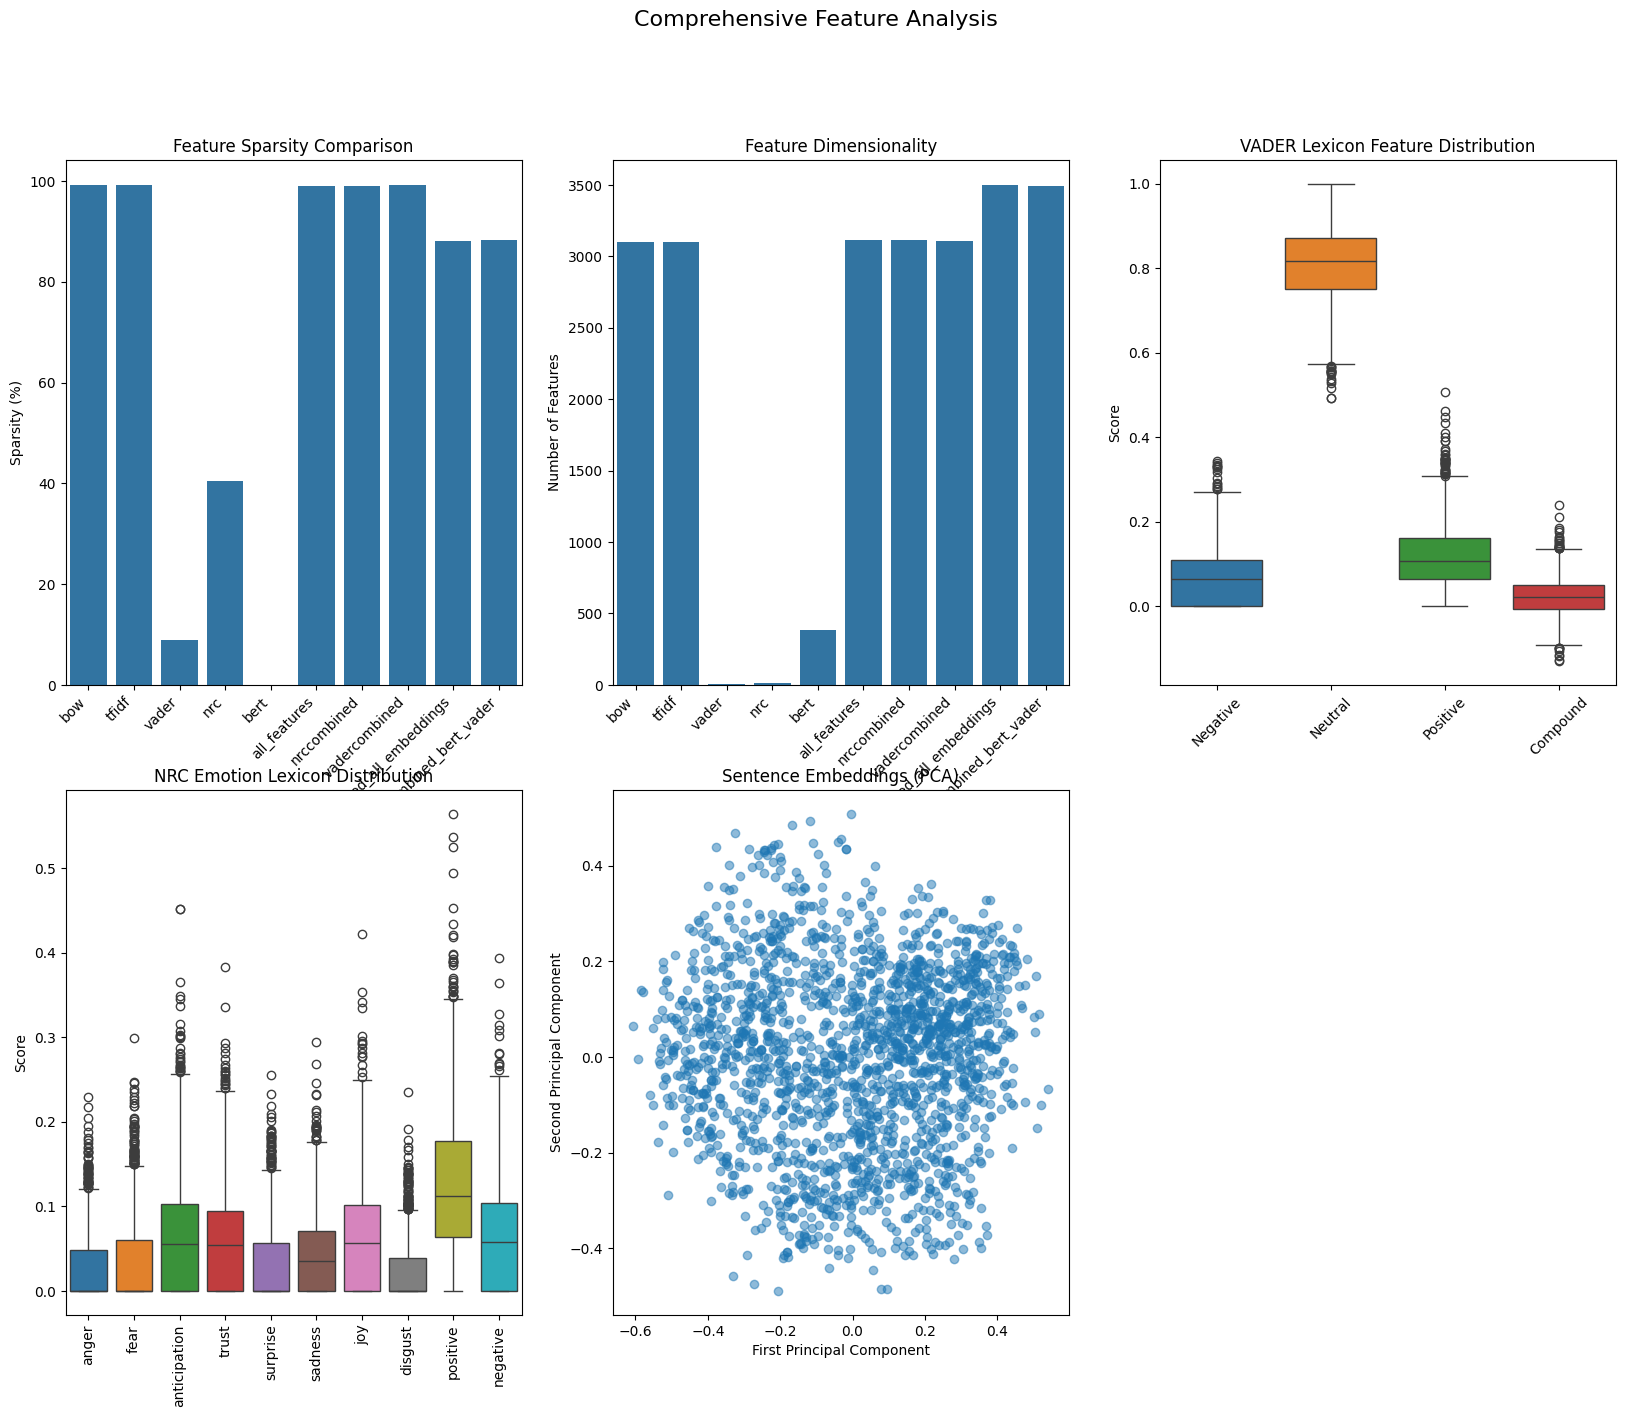

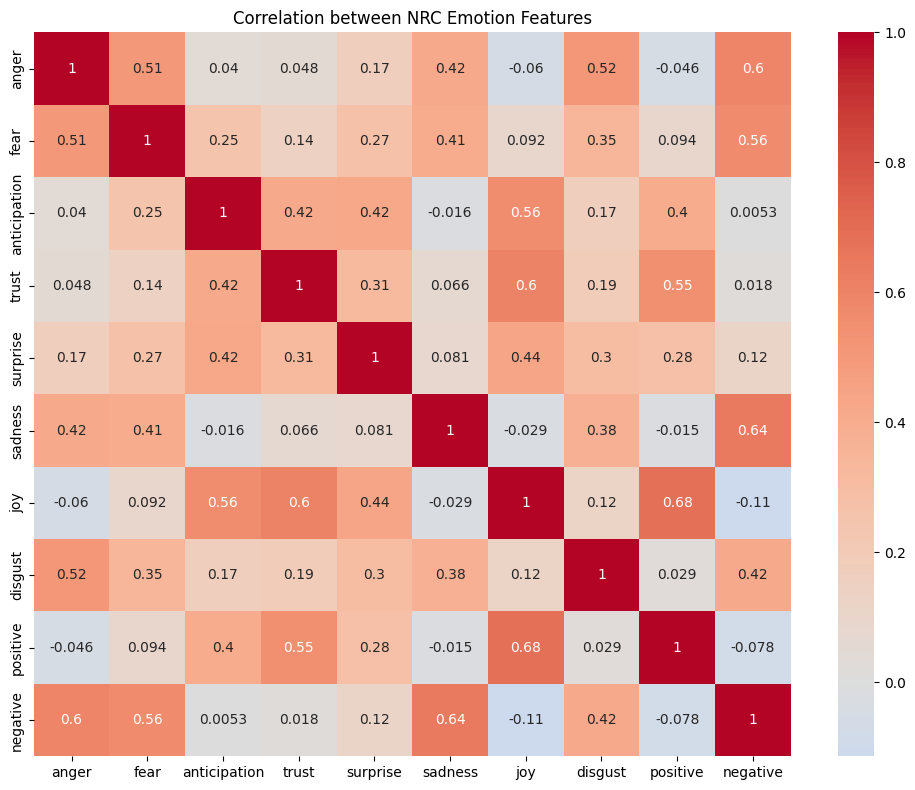

In [67]:

def visualize_features(features):
    """
    Create comprehensive visualizations of feature characteristics.
    
    Parameters:
    features (dict): Dictionary containing feature representations
    """
    # Create a larger figure with subplots
    plt.figure(figsize=(20, 15))
    plt.suptitle('Comprehensive Feature Analysis', fontsize=16)
    
    def calculate_sparsity(feature):
        """Calculate sparsity for different feature types"""
        if isinstance(feature, tuple):
            feature = feature[0]  # For bow, tfidf which return (matrix, vectorizer)
        
        if sp.issparse(feature):
            # Sparse matrix sparsity
            total_elements = feature.shape[0] * feature.shape[1]
            zero_elements = total_elements - feature.nnz
            sparsity = (zero_elements / total_elements) * 100
        elif isinstance(feature, np.ndarray):
            # Numpy array sparsity
            total_elements = feature.size
            zero_elements = np.count_nonzero(feature == 0)
            sparsity = (zero_elements / total_elements) * 100
        else:
            # For complex feature dictionaries
            if 'combined' in feature:
                feature = feature['combined']
                total_elements = feature.shape[0] * feature.shape[1]
                zero_elements = total_elements - feature.nnz
                sparsity = (zero_elements / total_elements) * 100
            else:
                return 0
        
        return sparsity
    
    # 1. Sparsity Comparison
    plt.subplot(2, 3, 1)
    sparsity_values = []
    feature_names = []
    
    for name, feature in features.items():
        try:
            sparsity = calculate_sparsity(feature)
            sparsity_values.append(sparsity)
            feature_names.append(name)
        except:
            pass
    
    sns.barplot(x=feature_names, y=sparsity_values)
    plt.title('Feature Sparsity Comparison')
    plt.xlabel('Feature Type')
    plt.ylabel('Sparsity (%)')
    plt.xticks(rotation=45, ha='right')
    
    # 2. Feature Shapes
    plt.subplot(2, 3, 2)
    shapes = []
    for name, feature in features.items():
        try:
            if isinstance(feature, tuple):
                shapes.append(feature[0].shape[1])
            elif isinstance(feature, np.ndarray):
                shapes.append(feature.shape[1])
            elif isinstance(feature, dict) and 'combined' in feature:
                shapes.append(feature['combined'].shape[1])
            else:
                shapes.append(0)
        except:
            shapes.append(0)
    
    sns.barplot(x=feature_names, y=shapes)
    plt.title('Feature Dimensionality')
    plt.xlabel('Feature Type')
    plt.ylabel('Number of Features')
    plt.xticks(rotation=45, ha='right')
    
    # 3. Distribution of VADER Features
    plt.subplot(2, 3, 3)
    if 'vader' in features and isinstance(features['vader'], np.ndarray):
        vader_features = features['vader']
        vader_columns = ['Negative', 'Neutral', 'Positive', 'Compound']
        sns.boxplot(data=vader_features)
        plt.title('VADER Lexicon Feature Distribution')
        plt.xticks(range(4), vader_columns, rotation=45)
        plt.ylabel('Score')
    
    # 4. Distribution of NRC Features
    plt.subplot(2, 3, 4)
    if 'nrc' in features and isinstance(features['nrc'], np.ndarray):
        nrc_features = features['nrc']
        nrc_emotions = ['anger', 'fear', 'anticipation', 'trust', 
                        'surprise', 'sadness', 'joy', 'disgust', 
                        'positive', 'negative']
        sns.boxplot(data=nrc_features)
        plt.title('NRC Emotion Lexicon Distribution')
        plt.xticks(range(10), nrc_emotions, rotation=90)
        plt.ylabel('Score')
    
    # 5. Embedding Dimensionality Reduction
    plt.subplot(2, 3, 5)
    if 'bert' in features and isinstance(features['bert'], np.ndarray):
        from sklearn.decomposition import PCA
        bert_embeddings = features['bert']
        pca = PCA(n_components=2)
        bert_pca = pca.fit_transform(bert_embeddings)
        plt.scatter(bert_pca[:, 0], bert_pca[:, 1], alpha=0.5)
        plt.title('Sentence Embeddings (PCA)')
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
    
    # Print summary statistics
    print("\n--- Feature Summary Statistics ---")
    for name, feature in features.items():
        try:
            if isinstance(feature, tuple):
                feature_matrix = feature[0]
            elif isinstance(feature, dict) and 'combined' in feature:
                feature_matrix = feature['combined']
            elif isinstance(feature, np.ndarray):
                feature_matrix = feature
            else:
                continue
            
            print(f"\n{name.upper()} Features:")
            if sp.issparse(feature_matrix):
                print(f"Shape: {feature_matrix.shape}")
                print(f"Sparsity: {calculate_sparsity(feature_matrix):.2f}%")
            else:
                print(f"Shape: {feature_matrix.shape}")
                print(f"Mean: {feature_matrix.mean()}")
                print(f"Std Dev: {feature_matrix.std()}")
        except Exception as e:
            print(f"Could not analyze {name}: {e}")
    # NRC Emotion Lexicon Insights
    print("\nNRC Emotion Lexicon Summary:")
    nrc_emotions = ['anger', 'fear', 'anticipation', 'trust', 'surprise', 
                    'sadness', 'joy', 'disgust', 'positive', 'negative']
    nrc_summary = pd.DataFrame(features['nrc'], columns=nrc_emotions)
    print(nrc_summary.describe())
    # Correlation Analysis
    print("\nCorrelation between NRC Emotion Features:")
    nrc_corr = nrc_summary.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(nrc_corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between NRC Emotion Features')
    plt.tight_layout()
    plt.show()
    

# Usage would be:
visualize_features(features)


--- Top Words Correlated with Sentiment ---

Top Positive Sentiment Words:
just: 0.3187
not: 0.2910
like: 0.2461
nothing: 0.2361
neutral: 0.2037
lately: 0.1973
either: 0.1940
feeling: 0.1917
feel: 0.1905
bad: 0.1795

Top Negative Sentiment Words:
the: -0.2715
for: -0.2362
of: -0.2320
sadness: -0.1976
felt: -0.1889
also: -0.1883
sense: -0.1748
bittersweet: -0.1721
wa: -0.1615
memory: -0.1603


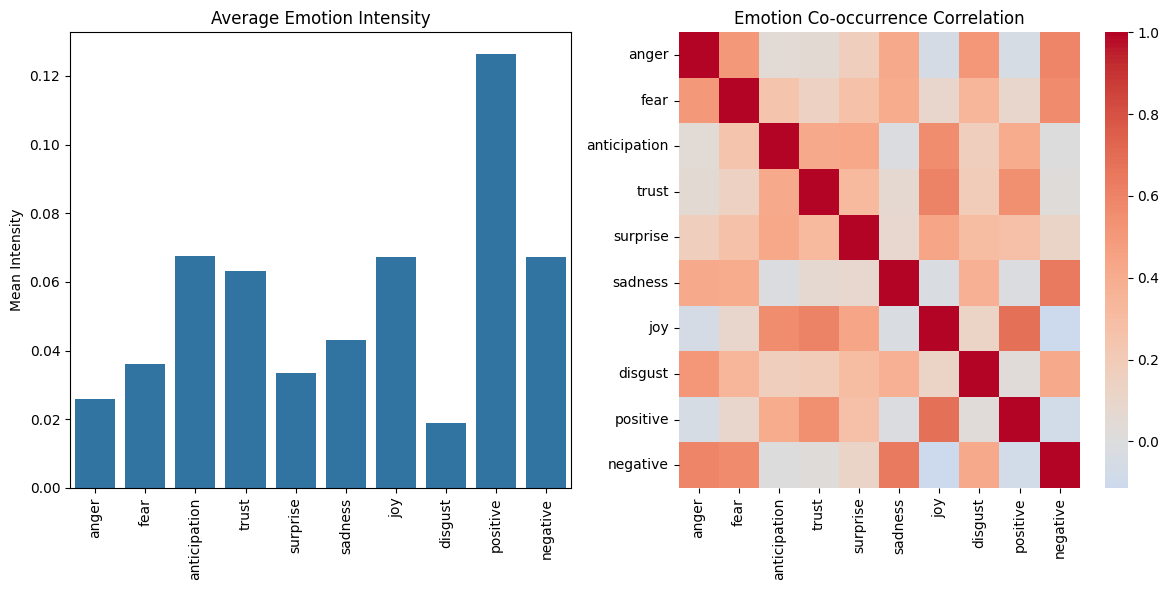

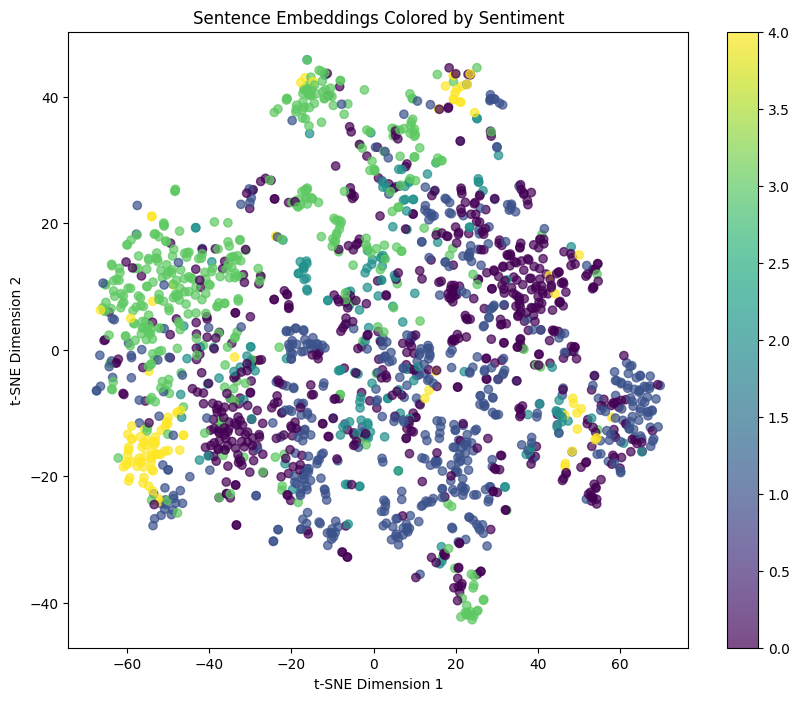

In [61]:

def advanced_feature_insights(features, df):
    # 1. Top Influential Words in TF-IDF
    tfidf_vectorizer = features['tfidf'][1]
    tfidf_features = features['tfidf'][0]
    
    # Calculate correlation with sentiment
    sentiment_numeric = pd.factorize(df['sentiment'])[0]
    
    feature_names = tfidf_vectorizer.get_feature_names_out()
    word_sentiment_corr = []
    
    for i in range(tfidf_features.shape[1]):
        feature_column = tfidf_features[:, i].toarray().flatten()
        corr, _ = pearsonr(feature_column, sentiment_numeric)
        word_sentiment_corr.append((feature_names[i], corr))
    
    # Sort by absolute correlation
    top_positive_words = sorted(word_sentiment_corr, key=lambda x: x[1], reverse=True)[:10]
    top_negative_words = sorted(word_sentiment_corr, key=lambda x: x[1])[:10]
    
    print("\n--- Top Words Correlated with Sentiment ---")
    print("\nTop Positive Sentiment Words:")
    for word, corr in top_positive_words:
        print(f"{word}: {corr:.4f}")
    
    print("\nTop Negative Sentiment Words:")
    for word, corr in top_negative_words:
        print(f"{word}: {corr:.4f}")
    
    # 2. Emotion Lexicon Depth Analysis
    vader_features = features['vader']
    nrc_features = features['nrc']
    
    # Emotion Intensity Distribution
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    emotion_intensities = nrc_features.mean(axis=0)
    emotion_names = ['anger', 'fear', 'anticipation', 'trust', 'surprise', 
                     'sadness', 'joy', 'disgust', 'positive', 'negative']
    
    sns.barplot(x=emotion_names, y=emotion_intensities)
    plt.title('Average Emotion Intensity')
    plt.xticks(rotation=90)
    plt.ylabel('Mean Intensity')
    
    # Emotion Co-occurrence
    plt.subplot(1, 2, 2)
    emotion_cooccurrence = np.corrcoef(nrc_features.T)
    sns.heatmap(emotion_cooccurrence, 
                xticklabels=emotion_names, 
                yticklabels=emotion_names, 
                cmap='coolwarm', center=0)
    plt.title('Emotion Co-occurrence Correlation')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Embedding Space Analysis
    bert_embeddings = features['bert']
    from sklearn.manifold import TSNE
    
    # Dimensionality Reduction with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    bert_tsne = tsne.fit_transform(bert_embeddings)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(bert_tsne[:, 0], bert_tsne[:, 1], 
                          c=sentiment_numeric, 
                          cmap='viridis', 
                          alpha=0.7)
    plt.colorbar(scatter)
    plt.title('Sentence Embeddings Colored by Sentiment')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# Call the advanced insights function
advanced_feature_insights(features, df)